In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from floyd_steinberg_dithering import floyd_steinberg_dithering, plot, insert_simple, paste_with_mask
from math import *
import io
import json
%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 

mpl.rcParams['figure.figsize'] = (10,6) 

In [2]:
def rotate_glichless(img, angle):
    m = cv2.getRotationMatrix2D((0,0), angle, 1.0)
    p1 = np.array([img.shape[1]/2, img.shape[0]/2])
    p2 = np.array([img.shape[1]/2, -img.shape[0]/2])

    ymax = max( abs(int(np.matmul(p1, m)[1])), abs(int(np.matmul(p2, m)[1])))
    xmax = max( abs(int(np.matmul(p2, m)[0])), abs(int(np.matmul(p1, m)[0])))
    if len(img.shape) == 2:
        img = np.reshape(img, (img.shape[0], img.shape[1], 1))
    img_big = np.zeros((max(ymax*2, img.shape[0]), max(xmax*2, img.shape[1]), img.shape[2]), dtype=img.dtype)
    x1 = int(img_big.shape[1]/2 - img.shape[1]/2)
    x2 = int(img_big.shape[1]/2 + img.shape[1]/2)
    y1 = int(img_big.shape[0]/2 - img.shape[0]/2)
    y2 = int(img_big.shape[0]/2 + img.shape[0]/2)
    insert_simple(img_big, img, x1,y1, x2, y2)
    
    image_center = tuple(np.array(img_big.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    res = cv2.warpAffine(img_big, rot_mat, img_big.shape[1::-1], flags=cv2.INTER_LINEAR)
    return res

def get_mask(img, angle):
    mask = np.zeros(img.shape[:2])
    mask[:,:] = 255
    mask = rotate_glichless(mask, angle)
    return mask == 255

def resize_max_gab(img, max_gab):
    fx = max_gab / img.shape[0] 
    fy = max_gab / img.shape[1] 
    return cv2.resize(img, (0,0), fx=min(fx,fy), fy=min(fx,fy))

class ImageCool(object):
    def __init__(self, max_gab=100, angle=0, fsd_factor=1):
        self.max_gab = max_gab
        self.angle = angle
        self.img=None
        self.mask=None
        self.img_fsd = None
        self.fsd_factor = fsd_factor
             
    def load_img(self, img):
        img = resize_max_gab(img, self.max_gab)
        self.img = rotate_glichless(img, self.angle)
        self.mask = get_mask(img, self.angle)
    
    def load_img_from_file(self, fname):
        img = cv2.imread(fname)
        self.load_img(img)
        
    def get_fsd(self, force=False, fsd_factor=None):
        if self.img_fsd is None or force:
            if fsd_factor is not None:
                self.fsd_factor = fsd_factor
            if self.fsd_factor is not None:
                self.fsd_factor = 1
            self.img_fsd = floyd_steinberg_dithering(self.img, self.fsd_factor)
        return self.img_fsd
        
    def plot(self, background=(0,0,255), fsd=False):
        res = np.zeros_like(self.img)
        res[:,:] = np.array(background[::-1])
        img = self.img
        if fsd:
            img = self.get_fsd()
        res[self.mask] = img[self.mask]
        plot(res)
        
    def insert_me_to(self, img, xc, yc, fsd=False):
        x, y = self.img.shape[1::-1]
        img2 = self.img
        if fsd:
            img2 = self.get_fsd()
        paste_with_mask(img, img2, self.mask, (xc,yc), (x/2,y/2))
        return img
        

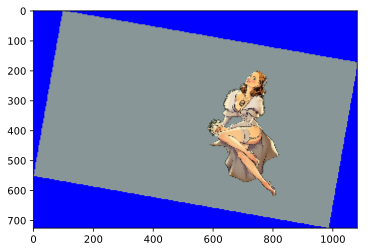

In [3]:
img_c = ImageCool(1000, -10)
img_c.load_img_from_file('imgs/game-of-thrones-sansa-stark-pinup-models-pinup-vintage-tv-se.jpg')
img_c.plot()

In [4]:
import pickle

In [5]:
img2 = cv2.imread('imgs/koshmas.png')
img_c2 = ImageCool(300, 30)
img_c2.load_img(img2)



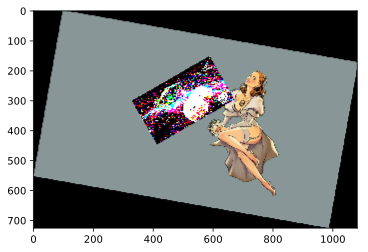

In [6]:
img_c2.insert_me_to(img_c.img, 500,300, True)

plot(img_c.img)

In [7]:
with open('db.bin', 'wb') as f:
    pickle.dump([img_c, img_c2], f)

In [8]:
with open('db.bin', 'rb') as f:
    s = pickle.load(f)

In [9]:
s

[<__main__.ImageCool at 0x2e1101fc4a8>, <__main__.ImageCool at 0x2e1101fc358>]

In [10]:
import glob
from tqdm import tqdm_notebook, tqdm
import random

In [14]:
for _ in tqdm(glob.glob('imgs/*')*3):
    pass

100%|█████████████████████████████████████████████████████████████████████████| 2151/2151 [00:00<00:00, 2156297.30it/s]


In [12]:
all_imgs = []

In [15]:
for fp in tqdm(glob.glob('imgs/*')*3):
    try:
        ic = ImageCool(max_gab=np.random.uniform(70,200),
                       angle=np.random.uniform(-60,60),fsd_factor=2)
        ic.load_img_from_file(fp)
        all_imgs.append(ic)
    except Exception as e:
        print(f'{fp}  {e}')
        

 33%|██████████████████████████▏                                                    | 714/2151 [01:36<03:25,  7.00it/s]

imgs\выборг1.jpg  'NoneType' object has no attribute 'shape'
imgs\выборг2.jpg  'NoneType' object has no attribute 'shape'
imgs\выборг3.jpg  'NoneType' object has no attribute 'shape'


 67%|███████████████████████████████████████████████████▉                          | 1431/2151 [03:14<01:48,  6.61it/s]

imgs\выборг1.jpg  'NoneType' object has no attribute 'shape'
imgs\выборг2.jpg  'NoneType' object has no attribute 'shape'
imgs\выборг3.jpg  'NoneType' object has no attribute 'shape'


100%|█████████████████████████████████████████████████████████████████████████████▉| 2148/2151 [04:55<00:00,  6.61it/s]

imgs\выборг1.jpg  'NoneType' object has no attribute 'shape'
imgs\выборг2.jpg  'NoneType' object has no attribute 'shape'
imgs\выборг3.jpg  'NoneType' object has no attribute 'shape'


100%|██████████████████████████████████████████████████████████████████████████████| 2151/2151 [04:55<00:00,  7.29it/s]


In [16]:
for ic in tqdm(all_imgs):
    ic.get_fsd(True, 3)

100%|████████████████████████████████████████████████████████████████████████████| 2142/2142 [2:31:16<00:00,  4.91s/it]


In [18]:
with open('all_imgs_fsd.bin', 'wb') as f:
    pickle.dump(all_imgs, f)